## Рекомендательные системы: предсказание оценки

Рассмотрим задачу предсказания оценки, которую пользователь поставит фильму. Особенность этой задачи в том, что объекты выборки описываются категориальными признаками, принимающими большое число значений (например: идентификатор пользователя, идентификатор фильма, тэги, киноперсоны).

Данные: [MovieLens + IMDb/Rotten Tomatoes](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-2k-v2.zip) ([описание](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-movielens-readme.txt)). Набор содержит данные о предпочтениях пользователей сервиса рекомендации кинофильмов [MovieLens](http://www.movielens.org/). Пользовательские оценки для фильмов принимают значения в интервале от 0.5 до 5.0, они записаны в файле *user_ratedmovies.dat* (а также в *user_ratedmovies-timestamps.dat*,  где для каждой оценки записана дата и время в формате timestamp), остальные файлы содержат дополнительную информацию о фильмах, которую можно использовать как признаки. Заметьте: кроме оценок (и тегов), про пользователя ничего не известно.

Задача: построить модель, предсказывающую оценку пользователя фильму, который он еще не смотрел.

Метрика качества: будем считать, что пользователю сервиса доступен блок рекомендаций, который может содержать рекомендации не более чем 5 фильмов.
Выберем некоторого пользователя $u$ и обозначим известные для него рейтинги за $R^u$. В качестве тестовых рейтингов $R^u_{test}$ для этого пользователя рассмотрим 5 рейтингов, поставленные последними по времени, в качестве валидационных $R^u_{val}$ — предпоследние 5 рейтингов. Остальные известные рейтинги этого пользователя будут составлять обучающую выборку $R^u_{train}$.
Для подбора гиперпараметров в рамках данного задания будем использовать валидационную выборку, предварительно обучив модель на обучающей выборке, а для финальной оценки качества — тестовую выборку, предварительно обучив модель на обучающей и валидационной выборках.

**1. (1 балл)** Загрузите данные и сформируйте 3 разреженные матрицы пользователи—фильмы для обучающих, валидационных и тестовых рейтингов пользователей соответственно, где в каждой ячейке стоит рейтинг, если он известен, или ноль, если неизвестен.

In [24]:
import numpy as np
import pandas as pd
from scipy import sparse
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
%matplotlib inline

In [2]:
ratings = pd.read_csv('user_ratedmovies-timestamps.dat', sep='\t')

In [3]:
ratings.head()

,userID,movieID,rating,timestamp
0,75,3,1.0,1162160236000
1,75,32,4.5,1162160624000
2,75,110,4.0,1162161008000
3,75,160,2.0,1162160212000
4,75,163,4.0,1162160970000


In [4]:
ratings.shape

(855598, 4)

In [5]:
len(ratings['userID'].unique())

2113

`userID` и `movieID` много раз повторяются и идут не подряд. Можно его заменить своим положением в отсортированной таблице (аналогично логике разреженной матрицы)

In [6]:
new_userIDs = dict()
userIDs = list(set(ratings['userID']))
userIDs.sort()
for i in range(len(userIDs)):
    new_userIDs[userIDs[i]] = i

new_movieIDs = dict()
movieIDs = list(set(ratings['movieID']))
movieIDs.sort()
for i in range(len(movieIDs)):
    new_movieIDs[movieIDs[i]] = i
ratings['compressed_userID'] = [new_userIDs[x] for x in ratings['userID']]
ratings['compressed_movieID'] = [new_movieIDs[x] for x in ratings['movieID']]

Сгруппируем по юзерам и разделим на train, test и val выборки.

In [9]:
train_df = pd.DataFrame(columns=ratings.columns)
val_df = pd.DataFrame(columns=ratings.columns)
test_df = pd.DataFrame(columns=ratings.columns)
grouped = list(ratings.groupby('compressed_userID'))
for item in grouped:
    df = item[1]
    if df.shape[0] < 11:
        continue
    df = df.sort_values(by='timestamp')
    to_test = df[-5:]
    to_val = df[-10:-5]
    to_train = df[:-10]
    train_df = train_df.append(to_train)
    test_df = test_df.append(to_test)
    val_df = val_df.append(to_val)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(834468, 6)
(10565, 6)
(10565, 6)


In [12]:
n_users = len(new_userIDs)
n_movies = len(new_movieIDs)

In [38]:
train_sm = sparse.csr_matrix((train_df['rating'].values,
                            (train_df['compressed_userID'].values,
                             train_df['compressed_movieID'].values)),
                            shape=(n_users, n_movies))
test_sm = sparse.csr_matrix((test_df['rating'].values,
                            (test_df['compressed_userID'].values,
                             test_df['compressed_movieID'].values)),
                            shape=(n_users, n_movies))
val_sm = sparse.csr_matrix((val_df['rating'].values,
                            (val_df['compressed_userID'].values,
                             val_df['compressed_movieID'].values)),
                            shape=(n_users, n_movies))

Качество рекомендаций: будем использовать метрики RMSE@k и nDCG@k для $k=5$, описанные ниже.

#### RMSE@k

Поскольку нас интересуют лишь фильмы, попавшие в блок рекомендаций, качество работы модели можно оценивать при помощи RMSE на $k$ фильмах с наибольшим предсказанным рейтингом, где $k$ — размер блока рекомендаций. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}$. Тогда RMSE@k:

$$ \text{RMSE@k}(u) = \sqrt{ \frac{1}{k} \sum_{i=1}^k (r_{u(i)} - \hat{r}_{u(i)})^2 },$$
$$ \text{RMSE@k} = \frac{1}{|U|} \sum_{u \in U} \text{RMSE@k}(u),$$
где $U$ — множество пользователей. При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

#### nDCG@k

Также можно использовать метрику качества ранжирования. Для этого для каждого пользователя $u$ предскажем оценку для всех фильмов из $R^u_{test}$ и отсортируем эти фильмы по убыванию предсказанного рейтинга. Ожидается, что хороший алгоритм должен выдать релевантные фильмы вверху списка. Отсортируем предсказанные моделью рейтинги $\hat{r}_{ui}$ в порядке убывания и обозначим $i$-ый элемент в полученной последовательности за $\hat{r}_{u(i)},$ а соответствующее этому фильму истинное значение рейтинга — за $r_{u(i)}.$

Тогда nDCG@k :

$$\text{DCG@k}(u) = \sum_{i=1}^k g(r_{u(i)}) d(i),$$
$$\text{nDCG@k}(u) = \frac{\text{DCG@k}(u)}{\max \text{DCG@k}(u)},$$
$$\text{nDCG@k} = \frac{1}{|U|} \sum_{u \in U} \text{nDCG@k}(u),$$
где $g(r)$ — функция полезности фильма, а  $d(i)$ — штраф за позицию.

Положим $g(r) = 2^r-1, \, d(i) = \frac{1}{\log_2 (i+1)}.$ При вычислении данной метрики все неизвестные оценки будем полагать равными 0.

**2. (2 балла)** Реализуйте функции rmse_score и ndcg_score, вычисляющие значения описанных выше метрик. Каждая из функций в качестве параметров должна принимать:
 * y_true — матрицу тестовых рейтингов (сформированную аналогично матрице тестовых рейтингов из предыдущего пункта; функция должна корректно работать и для разреженных, и для плотных матриц);
 * y_predicted — матрицу предсказаний модели в аналогичном формате (функция должна корректно работать и для разреженных, и для плотных матриц);
 * k — параметр $k$ в определениях метрик.

In [16]:
def rmse_score(y_true, y_predicted, k=5):
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = np.array(y_predicted)
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    else:
        y_true = np.array(y_true)
    sum_rmses = 0
    n = y_true.shape[0]
    diff_sqrs = (y_predicted - y_true) ** 2
    argsort = y_predicted.argsort(axis=1)[:, ::-1]
    for i in range(n):
        most_recommended = argsort[i][:k]
        sum_rmses += np.sqrt(diff_sqrs[i][most_recommended].mean())
    return sum_rmses / n

def ndcg_score(y_true, y_predicted, k=5):
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    else:
        y_predicted = np.array(y_predicted)
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    else:
        y_true = np.array(y_true)
    g = lambda r: 2 ** r - 1
    d = lambda i: 1 / np.log2(i + 2)
    max_dcg = g(5) * d(np.arange(k)).sum()
    if type(y_predicted) == type(sparse.csr_matrix([])):
        y_predicted = y_predicted.toarray()
    if type(y_true) == type(sparse.csr_matrix([])):
        y_true = y_true.toarray()
    n, m = y_true.shape
    dcg = []
    argsort = y_predicted.argsort(axis=1)[:, ::-1]
    for i in range(n):
        most_recommended = argsort[i][:k]
        true_ratings = y_true[i][most_recommended]
        dcg.append(np.sum(g(true_ratings) * d(np.arange(k))))
    dcg = np.array(dcg)
    return (dcg / max_dcg).mean()

**3. (1 балл)** Постройте рекомендации на основе **most popular** метода, при котором предсказанный рейтинг для некоторого фильма $i$ одинаков для всех пользователей и совпадает со средним значением рейтинга по всем пользователям, оценившим этот фильм, и вычислите значения метрик RMSE@5 и nDCG@5 для тестовой матрицы из п. 1.

In [17]:
nonzero = train_sm.nonzero()
ones = sparse.csr_matrix((np.ones_like(nonzero[0]), nonzero), shape=(n_users, n_movies))
avg_rating = train_sm.sum(axis=0) / ones.sum(axis=0)
avg_rating = np.array(np.nan_to_num(avg_rating))[0]

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in divide
  """


In [18]:
most_popular_prediction = np.tile(avg_rating, n_users).reshape((n_users, n_movies))

rmse = rmse_score(test_sm, most_popular_prediction)
ndcg = ndcg_score(test_sm, most_popular_prediction)

print('RMSE:', rmse)
print('NDCG:', ndcg)

('RMSE:', 4.9981612359105165)
('NDCG:', 0.000514153643899961)


Видим, что значения метрик низкие. Так как у всех пользователей разные предпочтения, то рекомендация всем пользователям одних и тех же популярных фильмов не даст очень хороших результатов. Нужно как-то учитывать предпочтения пользователей.

**4. (1 балл)** Реализуйте построение рекомендаций путём разложения матрицы рейтингов с помощью [разреженного SVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html) (в предположении, что неизвестные рейтинги заменяются на нули) и последующего её восстановления и постройте график зависимости метрик RMSE@5 и nDCG@5 от значения ранга разложения на валидационной выборке (рассмотрите как минимум 10 различных значений ранга разложения)

In [27]:
rmses = []
ndcgs = []
for d in range(5, 51, 5):
    svd = TruncatedSVD(n_components=d)
    reduced_matrix = svd.fit_transform(train_sm)
    prediction = np.dot(reduced_matrix, svd.components_)
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    rmses.append(rmse)
    ndcgs.append(ndcg)
    print('d: {}, RMSE: {}, nDCG: {}'.format(d, rmse, ndcg))

d: 5, RMSE: 3.19029126943, nDCG: 0.00793235976871
d: 10, RMSE: 3.42410728642, nDCG: 0.00663997126773
d: 15, RMSE: 3.59822418507, nDCG: 0.00635221265789
d: 20, RMSE: 3.72593467597, nDCG: 0.00649425848815
d: 25, RMSE: 3.82463117723, nDCG: 0.00503374871894
d: 30, RMSE: 3.87787843966, nDCG: 0.00534389156285
d: 35, RMSE: 3.92825408908, nDCG: 0.00435807142304
d: 40, RMSE: 4.00345160737, nDCG: 0.00437540941911
d: 45, RMSE: 4.0388256871, nDCG: 0.00379541576939
d: 50, RMSE: 4.07999588252, nDCG: 0.00373009425534


(0, 0.00814247304438136)

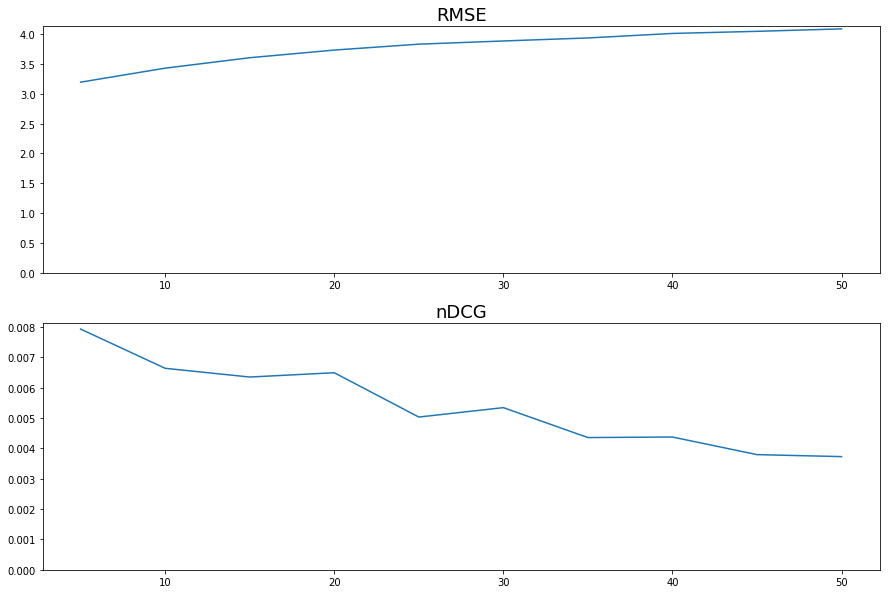

In [40]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.title('RMSE', fontsize=18)
plt.plot(range(5, 51, 5), rmses)
plt.ylim((0, None))
plt.subplot(2, 1, 2)
plt.title('nDCG', fontsize=18)
plt.plot(range(5, 51, 5), ndcgs)
plt.ylim((0, None))

**5. (3 балла)** Постройте рекомендации на основе user-based коллаборативной фильтрации. 
Предсказание модели $\hat{r}_{ui}$ вычисляйте по следующей формуле:
$$\hat{r}_{ui} = \bar{r}_{u} + \frac{\sum_{v \in U(u)} w_{uv} (r_{vi} - \bar{r}_v)}{\sum_{v \in U(u)} w_{uv}},$$
где $\bar{r}_u$ — средний ретинг пользователя $u$, $w_{uv}$ — мера сходства пользователей $u$ и $v$, $U(u) = \{ v \in U \, | \, w_{uv} > \alpha\}$ — коллаборация пользователя $u$. 

Значение параметра $\alpha$ возьмите равным 0.9.

Вычислите значения метрик RMSE@5 и nDCG@5 на тестовой выборке.

Матрица похожести $W$

In [33]:
W = np.corrcoef(train_sm.todense())

Для $\alpha$ от 0.1 до 0.5 с шагом 0.05 построим предсказание и посмотрим его RMSE и NDCG на валидации. Выберем то $\alpha$, на котором RMSE больше всего.

In [35]:
def user_based_collaborative_filtering(train_sm, alpha):
    r_mean = train_sm.sum(axis=1) / ones.sum(axis=1)
    r_mean = np.array(r_mean).T[0]
    prediction = []
    for u in range(n_users):
        U = np.array(W[u] > alpha).nonzero()[0]
        w = W[u][U]
        R = train_sm[U, :]
        sum_of_collab = np.dot(w, (R.T - r_mean[U]).T)
        sum_of_collab = np.array(sum_of_collab)[0]
        our_prediction = r_mean[u] + sum_of_collab / w.sum()
        prediction.append(our_prediction)
    prediction = np.array(prediction)
    return prediction

In [36]:
for alpha in np.arange(0.5, 0.09, -0.05):
    min_rmse = 5
    prediction = user_based_collaborative_filtering(train_sm, alpha)
    rmse = rmse_score(val_sm, prediction)
    ndcg = ndcg_score(val_sm, prediction)
    print('alpha = {}, rmse: {}, ndcg: {}'.format(alpha, rmse, ndcg))
    if rmse < min_rmse:
        min_rmse = rmse
        best_alpha = alpha

alpha = 0.5, rmse: 4.85732182694, ndcg: 0.0
alpha = 0.45, rmse: 4.75382094356, ndcg: 0.0
alpha = 0.4, rmse: 4.60387780772, ndcg: 0.000114852392438
alpha = 0.35, rmse: 4.43084755512, ndcg: 0.000478317287077
alpha = 0.3, rmse: 4.2462718996, ndcg: 0.000801051656065
alpha = 0.25, rmse: 4.05399326686, ndcg: 0.00133101599655


KeyboardInterrupt: 

In [42]:
# Прогноз с beta_alpha
#
prediction = user_based_collaborative_filtering(train_sm, best_alpha)

**6. (1 балл)** Какой метод оказался лучше по каким метрикам? Почему?

При сравнении методов стоит понимать, что очень большое число рейтингов для фильмов неизвестно, поэтому RMSE получалась завышенной, а nDCG - наоборот, заниженной.

Тем не менее, можно сказать, что эвристика подхода most popular - выдавать среднюю оценку для фильма слишком проста, чтобы хорошо работать для индивидуальных рекомендаций, ужасные результаты на метриках это подтверждают. Очевидно, этот подход плох тем, что он совершенно не учитывает индивидуальные предпочтения пользователя.

Метод с разреженным SVD с точки зрения метрик в некоторой степени можно считать лучшим, однако стоит понимать, что цель SVD - построить лучшее приближение исходной матрицы, матрицей заданного ранга. Таким образом при больших значениях ранга разложения (при которых получаем хорошие оценки с точки зрения метрик), на выходе метода получим матрицу очень близкую к исходной и, например, не сделаем разумных прогнозов рейтингов для фильмов, которые пользователь не смотрел (рейтинги останутся близкими к нулю, при малом значении ранга эта ситуация сильно не меняется).

User-based коллаборативная фильтрация показала вполне адекватные результаты, при этом она позволяет проставить разумные оценки фильмам, которые пользователь не смотрел. Ошибка RMSE - 1,9 большая, но стоит помнить о том, что в матрице test очень мало известных рейтингов. Метрика nDCG также пострадала от нехватки большого числа рейтингов но все же показывает результат 0.65. Поскольку значение nDCG $\in [0,1]$, можно сделать вывод, что модель все же ранжирует фильмы лучше чем случайным образом.


В most popular значения метрик низкие. Так как у всех пользователей разные предпочтения, то рекомендация всем пользователям одних и тех же популярных фильмов не даст очень хороших результатов. Нужно как-то учитывать предпочтения пользователей.

Затем RMSE почти не изменилось. NDCG стало хуже. Причина, скорее всего, в том, что у пользователей, которые смотрят непопулярные фильмы, очень мало других похожих пользователей, и user-based подход не может на них хорошо работать.

С точки зрения обеих метрик, качество предсказания на TruncatedSVD лучше при малых значениях ранга разложения.

**7. (1 балл)** Приведите достоинства и недостатки используемых метрик. Какие еще метрики можно было бы использовать для решения задачи? Приведите примеры других постановок задачи, как в этом случае можно было бы оценить качество?

По обеим метрикам лучше всего качество у факторизационных машин. Это объясняется тем, что они предсказывают оценки только на тех фильмах, на которых реальные оценки известны. В остальных моделях оценки предсказывались по каждому фильму для всех пользователей, и при вычислении метрик неизвестные оценки считались равными нулю, поэтому значение $r_{u(i)}$ в большинстве слагаемых было нулем, из-за чего значения метрик были гораздо хуже.

Из остальных моделей лучшее значение nDCG@5 показывает разреженный SVD, а лучшее значение RMSE@5 у модели со скрытыми переменными. Первое объясняется тем, что SVD - самый продвинутый из использованных нами методов (модель со скрытыми переменными, по сути, является SVD с рангом разложения 1, а user-based коллаборативная фильтрация учитывает информацию о пользователях, но не учитывает информацию о фильмах). Второе объясняется, скорее всего, тем, что из-за нормировки оценки стали ближе к нулю - самому часто встречающемуся значению в тестовой выборке.